---
title: "Cointegrated time-series and when differencing might be bad"
author: "Sarem"
date: "2022-08-25"
categories: [Time Series]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "You have heard about integrated time-series data but what about cointegration?"
---

## Introduction

A standard method in the time-series analysis toolkit are [difference transformations or *differencing*](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/?ref=sarem-seitz.com). Despite being dead simple, differencing can be quite powerful. [In fact, it allows us to outperform sophisticated time-series models with what is almost a bare white noise process](https://www.sarem-seitz.com/facebook-prophet-covid-and-why-i-dont-trust-the-prophet/).

Due to its simplicity, differencing is quite popular whenever some unit-root test is significant. While this is fairly safe in the univariate case, things look differently for multivariate time-series.

Let us demonstrate this with a simple example:

## A motivating time-series example
To exemplify the underlying issue, I created an artificial, two-dimensional and linear time-series:

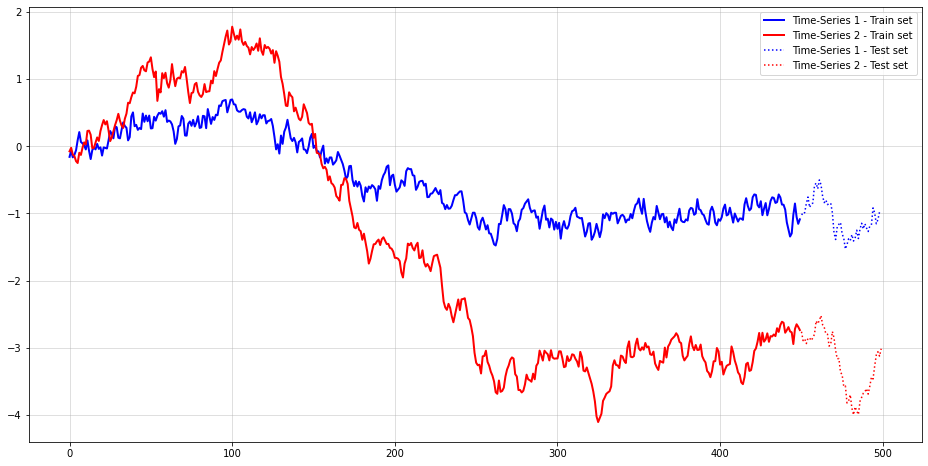

In [1]:
import numpy as np
import matplotlib.pyplot as plt

A = np.array([[0.2],[-0.3]])
B = np.array([[-0.9],[0.3]])

Atilde = A@B.T


sigma = np.array([[0.1],[0.1]])

np.random.seed(987)

ys = [np.random.normal(size=(2,1))*sigma]
for t in range(500):    
    dy = Atilde@ys[-1] + np.random.normal(size=(2,1))*sigma
    ys.append(ys[-1] + dy)
 
Y = np.concatenate(ys,1).T[1:,:]

Ytrain = Y[:-50,:]
Ytest = Y[-50:,:]

forecast_range = np.arange(len(Ytrain),len(Ytrain)+len(Ytest))

plt.figure(figsize=(16,8))
plt.plot(Ytrain[:,0],c="blue", label="Time-Series 1 - Train set",lw=2)
plt.plot(Ytrain[:,1],c="red", label="Time-Series 2 - Train set",lw=2)
plt.plot(forecast_range, Ytest[:,0],c="blue", ls="dotted", label="Time-Series 1 - Test set")
plt.plot(forecast_range, Ytest[:,1],c="red", ls="dotted", label="Time-Series 2 - Test set")

plt.grid(alpha=0.5)
plt.legend()

There seems to be some connection between both time-series but that might obviously just be a [spurious one](https://en.wikipedia.org/wiki/Spurious_relationship?ref=sarem-seitz.com) over time. The next step that you often see done in this setting is to test for unit-roots in both time-series.

An [Augmented-Dickey Fuller test from statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html?ref=sarem-seitz.com) shows significance scores of 0.8171 and 0.8512. This underlines the visible unit-roots in both time-series. Thus, the difference transformation appears to be the logical next step. Let's do that for the train set to forecast the test set further down the line:

Text(0.5, 1.0, 'Time Series 2 - Train set differenced')

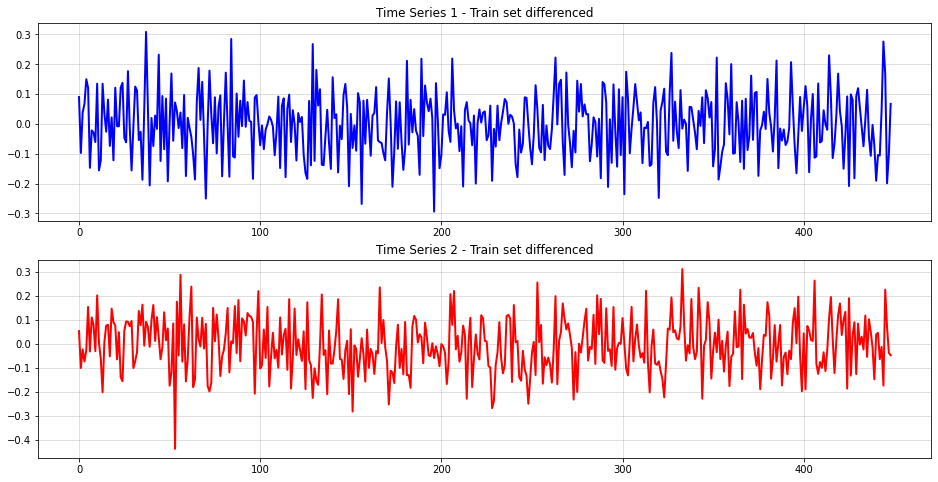

In [2]:
Ytrain_diff = Ytrain[1:,:]-Ytrain[:-1,:]
fig, ax = plt.subplots(2, 1, figsize = (16,8))
ax[0].plot(Ytrain_diff[:,0], c="blue", lw=2)
ax[0].grid(alpha=0.5)
ax[0].set_title("Time Series 1 - Train set differenced")

ax[1].plot(Ytrain_diff[:,1], c="red", lw=2)
ax[1].grid(alpha=0.5)
ax[1].set_title("Time Series 2 - Train set differenced")

Next, we can check forecast performance for two VAR(1) models - one trained on the original time-series and one on the transformed one:

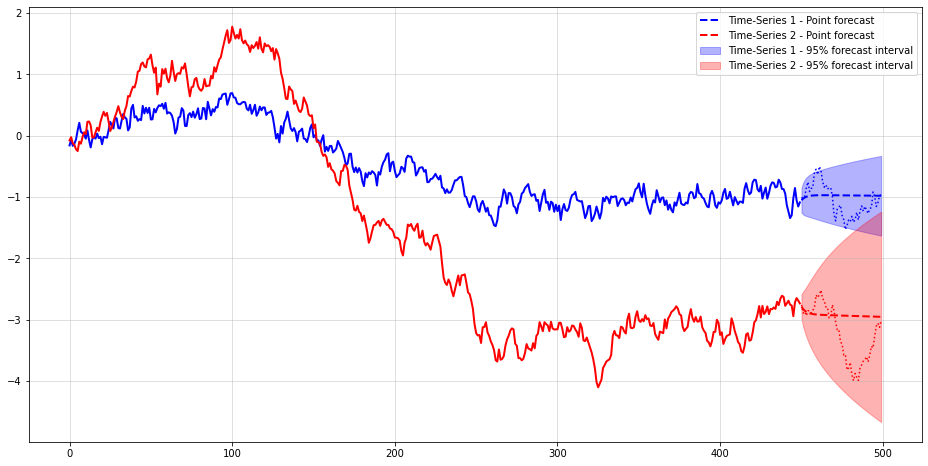

In [3]:
from statsmodels.tsa.api import VAR
from scipy.stats import norm

model_nodiff = VAR(Ytrain).fit(1,trend='n')

pred_mean_nodiff = model_nodiff.forecast(Ytrain,steps=len(Ytest))
pred_std_nodiff = np.sqrt(np.array(list(map(lambda x: np.diag(x),list(model_nodiff.forecast_cov(steps=len(Ytest)))))))
pred_lower_nodiff = norm(pred_mean_nodiff,pred_std_nodiff).ppf(0.025)
pred_upper_nodiff = norm(pred_mean_nodiff,pred_std_nodiff).ppf(0.975)


plt.figure(figsize=(16,8))

plt.plot(Ytrain[:,0],c="blue",lw=2)
plt.plot(Ytrain[:,1],c="red",lw=2)
plt.plot(forecast_range, Ytest[:,0],c="blue", ls="dotted")
plt.plot(forecast_range, Ytest[:,1],c="red", ls="dotted")

plt.plot(forecast_range, pred_mean_nodiff[:,0],c="blue",ls="dashed",lw=2, label="Time-Series 1 - Point forecast")
plt.plot(forecast_range, pred_mean_nodiff[:,1],c="red",ls="dashed",lw=2, label="Time-Series 2 - Point forecast")
plt.fill_between(forecast_range, pred_lower_nodiff[:,0], pred_upper_nodiff[:,0],color="blue",alpha=0.3,label="Time-Series 1 - 95% forecast interval")
plt.fill_between(forecast_range, pred_lower_nodiff[:,1], pred_upper_nodiff[:,1],color="red",alpha=0.3,label="Time-Series 2 - 95% forecast interval")

plt.grid(alpha=0.5)
plt.legend()

The summed MSE over both time-series forecasts is at `0.3463`. Clearly, the model with training data differenced should perform better:

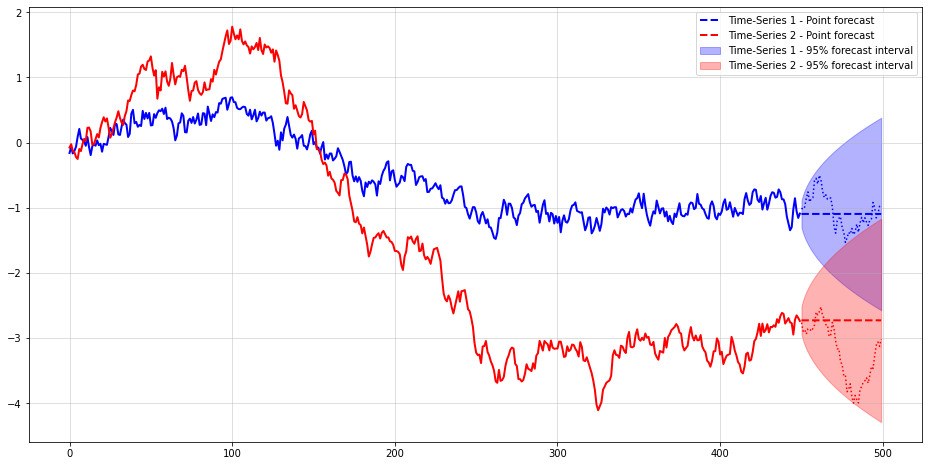

In [4]:
model_diff = VAR(Ytrain_diff).fit(1,trend='n')

pred_mean_diff = Ytrain[-1,:].reshape(1,-1)+np.cumsum(model_diff.forecast(Ytrain_diff,steps=len(Ytest)),0)
pred_std_diff = np.sqrt(np.cumsum(np.array(list(map(lambda x: np.diag(x),list(model_diff.forecast_cov(steps=len(Ytest)))))),0))
pred_lower_diff = norm(pred_mean_diff,pred_std_diff).ppf(0.025)
pred_upper_diff = norm(pred_mean_diff,pred_std_diff).ppf(0.975)


plt.figure(figsize=(16,8))

plt.plot(Ytrain[:,0],c="blue",lw=2)
plt.plot(Ytrain[:,1],c="red",lw=2)
plt.plot(forecast_range, Ytest[:,0],c="blue", ls="dotted")
plt.plot(forecast_range, Ytest[:,1],c="red", ls="dotted")

plt.plot(forecast_range, pred_mean_diff[:,0],c="blue",ls="dashed",lw=2, label="Time-Series 1 - Point forecast")
plt.plot(forecast_range, pred_mean_diff[:,1],c="red",ls="dashed",lw=2, label="Time-Series 2 - Point forecast")
plt.fill_between(forecast_range, pred_lower_diff[:,0], pred_upper_diff[:,0],color="blue",alpha=0.3,label="Time-Series 1 - 95% forecast interval")
plt.fill_between(forecast_range, pred_lower_diff[:,1], pred_upper_diff[:,1],color="red",alpha=0.3,label="Time-Series 2 - 95% forecast interval")

plt.grid(alpha=0.5)
plt.legend()

This time, the summed MSE is `0.5105` - approximately 50% higher. Also, the forecast interval for time-series 1 is much larger than without any differencing. Something seems to be off with the popular difference transformation.

## Why cointegration matters
Right now, you might - rightfully - argue that the underperformance of the differencing model was due to pure chance. Indeed, we would need much broader experiments to verify our initial claim empirically.

It is, however, possible to actually prove why differencing can be bad for multivariate time-series analysis. To do so, let us take a step back to univariate time-series models and why difference transformations work here.

We will only look at AR(1) and VAR(1) time-series for simplicity. All results can be shown to hold for higher-order AR/VAR, too.

### Unit-Root AR(1) time-series - when differencing is likely safe
Mathematically, an AR(1) time-series looks as follows:
$$
\begin{aligned}
y_t & =\phi_1 y_{t-1}+\epsilon_t \\
\epsilon_t & \sim \mathcal{N}\left(0, \sigma^2\right)
\end{aligned}
$$
In order for differencing to make sense, we need the time-series to have a unit root. This is the case when solution of characteristic polynomial
$$
1-\phi_1 z=0
$$
lies on the unit-circle, i.e.
$$
z=1.
$$
The only choice for the AR-parameter is therefore
$$
\phi_1=1
$$
and thus
$$
y_t=y_{t-1}+\epsilon_t.
$$
To make this equation stationary, we subtract the lagged variable from both sides:
$$
\begin{gathered}
y_t-y_{t-1}=y_{t-1}-y_{t-1}+\epsilon_t \\
\Rightarrow \Delta y_t=\epsilon_t
\end{gathered}
$$
Clearly, the best possible forecast now is to predict white noise. Keep in mind that we could equally well fit a model on the untransformed variable. However, the differenced time-series directly uncovers the lack of any truly autoregressive component.

On the one hand, differencing is clearly a good choice in univariate time-series with unit-roots. Things are not as simple for multivariate time-series, though.

### Multivariate time-series with cointegration
Consider now a VAR(1) time where we replace the scalars in the AR(1) model with vectors (bold, lower-case) and vectors (upper case):
$$
\begin{gathered}
\mathbf{y}_{\mathbf{t}}=A \mathbf{y}_{\mathbf{t}-\mathbf{1}}+\mathbf{u}_{\mathbf{t}} \\
\mathbf{u}_{\mathbf{t}} \sim \mathcal{N}(\mathbf{0}, \Sigma)
\end{gathered}
$$
A unit-root in a VAR(1) time-series imply, similarly to the AR(1) case, that
$$
\operatorname{det}(I-A)=0.
$$
In the trivial case, the autoregression parameter is the identity matrix. This implies that the marginals in our VAR(1) time-series are all independent and unit-root. If we exclude this case and proceed as for AR(1), we get
$$
\begin{gathered}
\mathbf{y}_{\mathbf{t}}-\mathbf{y}_{\mathbf{t}-\mathbf{1}}=A \mathbf{y}_{\mathbf{t}-\mathbf{1}}-\mathbf{y}_{\mathbf{t}-\mathbf{1}}+\mathbf{u}_{\mathbf{t}} \\
\Rightarrow \Delta \mathbf{y}_{\mathbf{t}}=-(I-A) \mathbf{y}_{\mathbf{t}-\mathbf{1}}+\mathbf{u}_{\mathbf{t}} \\
\Rightarrow \Delta \mathbf{y}_{\mathbf{t}}=\tilde{A} \mathbf{y}_{\mathbf{t}-\mathbf{1}}+\mathbf{u}_{\mathbf{t}}
\end{gathered}
$$
The last line is also called an [Vector Error Correcting Representation](https://en.wikipedia.org/wiki/Error_correction_model?ref=sarem-seitz.com) of a VAR time-series. If you scroll back to our simulation, this is the exact formula that was used to generate the time-series.

By making Atilde rank-deficient, the time-series becomes cointegrated, as explained by [Lütkepohl](https://www.google.com/books/edition/New_Introduction_to_Multiple_Time_Series/muorJ6FHIiEC?hl=de&gbpv=1&dq=l%C3%BCtkepohl&pg=PA249&printsec=frontcover&ref=sarem-seitz.com). There exists another, [broader definition of cointegration](https://www.youtube.com/watch?v=vvTKjm94Ars&ab_channel=BenLambert&ref=sarem-seitz.com) but we won't cover that today.

Clearly, a cointegrated VAR(1) time-series differs from the univariate AR(1) case. Even after differencing, the transformed values depend on the past of the original time-series. We would therefore lose important information if we don't account for the original time-series anymore.

If you are working with multivariate data, you should therefore not just blindly apply differencing.

## How to deal with cointegration
The above result begs the question of what we should do to handle cointegration. Typically, time-series analysis is concerned either with forecasting or inference. Therefore, two different approaches come to mind:

**Cross-validation and backtesting** - the pragmatic, 'data sciency' approach. If our goal is primarily to build the most accurate forecast, we don't necessarily need to detect cointegration at all. As long as the resulting model is performant and reliable, nearly anything goes.

As usually, the 'best' model can be selected based on cross-validation and out-of-sample performance tests. The primary implication from cointegration is then to apply differencing with some care.

On the other hand, the above result also suggests that adding the original time-series as a feature might be a good idea in general.

**Statistical tests** - the classical statistics way. Obviously, cointegration is nothing new to econometricians and statisticians. If you are interested in learning about the generating process itself, this approach is likely more expedient.

Luckily, the [work of James MacKinnon](https://scholar.google.com/scholar?hl=de&as_sdt=0%2C5&q=mackinnon+cointegration&btnG=&oq=mackinnon+coint&ref=sarem-seitz.com) provides extensive insights into tests for cointegration. Other popular cointegration tests have been developed by [Engle and Granger](https://scholar.google.com/scholar?hl=com&as_sdt=0%2C5&q=engle+granger+cointegration+test&btnG=&oq=engle+gran&ref=sarem-seitz.com) and [Søren Johansen](http://jerrydwyer.com/pdf/Clemson/Cointegration.pdf?ref=sarem-seitz.com).

In Python, you can find the MacKinnon test in the [statsmodels library](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html?ref=sarem-seitz.com). For the above time-series, the test yields a p-value of almost zero.

## Conclusion
Hopefully, this article was an eye-opener to you to not just difference every time-series straight ahead. You should be aware by now that cointegration is a peculiarity of multivariate time-series that needs to be treated with care.

Keep in mind that standard cointegration is concerned with linear time-series only. Once non-linear dynamics are present, things could become even more messy and differencing might be even less suitable.

Indeed, there exists some [recent research on non-linear cointegration](https://www.tandfonline.com/doi/full/10.1080/07474938.2020.1771900?ref=sarem-seitz.com). You might want to take a look at it for further details.

## References
**[1]** Engle, Robert F.; Granger, Clive WJ. Co-integration and error correction: representation, estimation, and testing. Econometrica: journal of the Econometric Society, 1987, p. 251-276.

**[2]** Hamilton, James Douglas. Time series analysis. Princeton university press, 2020.

**[3]** Lütkepohl, Helmut. New introduction to multiple time series analysis. Springer Science & Business Media, 2005.